Validation du modèle avec les données de 2023

### Preprocessing functions...

In [3]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## TrackStatus ----------------------------------------------------------------

def trackStatus_to_binary(df):
    trackStatus = df['TrackStatus']
    status = pd.Series(
        np.zeros(6, dtype=np.bool_),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

def process_trackStatus(df):
    trackStatuses = df.apply(trackStatus_to_binary, axis=1)
    return pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1).reset_index(drop=True)

## Missing Data ----------------------------------------------------------------

def process_missing_values(df):
    # TODO fill the missing values better
    df.fillna({
        'DistanceToDriverAhead': -1,
        'GapToLeader': -1,
        'IntervalToPositionAhead': -1,
        'LapTime': -1,
    }, inplace=True)

    # drop all rows with missing laptime if pit status is not NoPit
    #df.dropna(subset=['LapTime'], inplace=True)
    #df.where(df['PitStatus'] != 'NoPit').fillna({'LapTime': -1,}, inplace=True)
    return df[df['LapNumber'] > 1]

## Datatypes -------------------------------------------------------------------

def process_datatypes(df):
    # boolean
    df['Green'] = df['Green'].astype('bool')
    df['Yellow'] = df['Yellow'].astype('bool')
    df['SC'] = df['SC'].astype('bool')
    df['Red'] = df['Red'].astype('bool')
    df['VSC'] = df['VSC'].astype('bool')
    df['SC_ending'] = df['SC_ending'].astype('bool')
    df['IsAccurate'] = df['IsAccurate'].astype('bool')
    df['Rainfall'] = df['Rainfall'].astype('bool')
    # category
    df['DriverNumber'] = df['DriverNumber'].astype('category')
    df['Team'] = df['Team'].astype('category')
    df['Compound'] = df['Compound'].astype('category')
    df['DriverAhead'] = df['DriverAhead'].astype('category')
    df['Track'] = df['Track'].astype('category')
    # float
    df['LapStartTime'] = df['LapStartTime'].astype('float32')
    df['LapTime'] = df['LapTime'].astype('float32')
    df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
    df['GapToLeader'] = df['GapToLeader'].astype('float32')
    df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
    df['AirTemp'] = df['AirTemp'].astype('float32')
    df['Humidity'] = df['Humidity'].astype('float32')
    df['Pressure'] = df['Pressure'].astype('float32')
    df['TrackTemp'] = df['TrackTemp'].astype('float32')
    df['WindDirection'] = df['WindDirection'].astype('float32')
    df['WindSpeed'] = df['WindSpeed'].astype('float32')
    # int
    df['LapNumber'] = df['LapNumber'].astype('uint8')
    df['TyreLife'] = df['TyreLife'].astype('uint8')
    df['Stint'] = df['Stint'].astype('uint8')
    df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
    df['Position'] = df['Position'].astype('uint8')
    df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
    df['TotalLaps'] = df['TotalLaps'].astype('uint8')
    return df

## Add target ------------------------------------------------------------------

def process_target(df):
    df['is_pitting'] = df['PitStatus'] == 'InLap'
    df['is_pitting'] = df['is_pitting'].astype('bool')
    return df

## Remove features -------------------------------------------------------------

def process_remove_features(df):
    df.drop(['LapStartTime', 'DriverNumber', 'Team', 'DriverAhead', 
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'PitStatus', 'IsAccurate'], axis=1, inplace=True)
    return df

## Feature encoding ------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder

def process_feature_encoding(df):
    categorical_features = ['Compound', 'Track']
    one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    one_hot_encoder.fit(df[categorical_features])
    one_hot_encoded = one_hot_encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))
    print("One hot : ", one_hot_encoded.shape)
    print("Data : ", df.shape)
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df, one_hot_encoder


def process_feature_encoding_new(df, encoder):
    categorical_features = ['Compound', 'Track']
    one_hot_encoded = encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df

def preprocess_new_data(df, encoder):
    #print('Preprocessing data...', df.shape)
    df = process_trackStatus(df)
    #print('TrackStatus processed...', df.shape)
    df = process_missing_values(df)
    #print('Missing values processed...', df.shape)
    df = process_datatypes(df)
    #print('Datatypes processed...', df.shape)
    df = process_target(df)
    #print('Target processed...', df.shape)
    df = process_remove_features(df)
    #print('Features removed...', df.shape)
    df = process_feature_encoding_new(df, encoder)
    #print('Features encoded...', df.shape)
    return df

### 1. Chargement des données

In [4]:
# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

base_path = 'models/comparisons'

data_path = 'data/2023'

models_path = 'models'

model_names = [
    'specificity',
    'sensitivity',
    'balanced_accuracy',
]

figures_path = os.path.join(base_path, 'figures')

model_save_name = 'model.pkl'
encoder_save_name = 'encoder.pkl'

os.makedirs(base_path, exist_ok=True)
os.makedirs(figures_path, exist_ok=True)

type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool_,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

In [5]:
def get_data(data_path, type_dict):
    data = pd.DataFrame()
    for file in os.listdir(data_path):
        if file.endswith('.csv'):
            file_data = pd.read_csv(os.path.join(data_path, file), dtype=type_dict)
            if file_data['Rainfall'].any() == False:
                data = pd.concat([data, file_data], ignore_index=True)
    return data

def get_models(model_names, models_path):
    models = {}
    for model_name in model_names:
        model_path = os.path.join(models_path, model_name, model_save_name)
        models[model_name] = pickle.load(open(model_path, 'rb'))
    return models

def get_encoder(model_names, models_path):
    encoder_path = os.path.join(models_path, model_names[0], encoder_save_name)
    encoder = pickle.load(open(encoder_path, 'rb'))
    return encoder

def get_preprocessed_data(data, encoder):
    data = preprocess_new_data(data, encoder)
    data.dropna(inplace=True)
    x = data.drop(['is_pitting'], axis=1)
    y = data['is_pitting']
    return x, y

In [6]:
data = get_data(data_path, type_dict)
encoder = get_encoder(model_names, models_path)
models = get_models(model_names, models_path)
x, y = get_preprocessed_data(data, encoder)

In [7]:
from sklearn.metrics import confusion_matrix, f1_score

def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn+fp)

def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp+fn)

def balanced_accuracy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    return (specificity + sensitivity) / 2

def get_preds(model, X, proba=False):
    def extract(ys):
        if len(ys.shape) == 1:
            return ys
        return [y[1] for y in ys]
    
    if proba:
        preds = model.predict_proba(np.array(X).astype('float32'))
        return extract(preds)
    else:
        preds = model.predict(np.array(X).astype('float32'))
        return extract(preds.round())
    
def get_metrics(model, X, y):
    preds = get_preds(model, X)
    return {
        'specificity_val': specificity(y, preds),
        'sensitivity_val': sensitivity(y, preds),
        'balanced_accuracy_val': balanced_accuracy(y, preds),
        'f1_score_val': f1_score(y, preds),
    }

def get_metrics_df(models, x, y):
    metrics = {}
    for model_name, model in models.items():
        metrics[model_name] = get_metrics(model, x, y)
    return pd.DataFrame(metrics).transpose()

def get_preds_df(models, x, proba=False):
    preds = {}
    for model_name, model in models.items():
        preds[model_name] = get_preds(model, x, proba=proba)
    return pd.DataFrame(preds)

In [8]:
metrics_df = get_metrics_df(models, x, y)
metrics_df

,specificity_val,sensitivity_val,balanced_accuracy_val,f1_score_val
specificity,0.993746,0.165975,0.579860,0.245399
sensitivity,0.808200,0.593361,0.700781,0.162132
balanced_accuracy,0.899236,0.489627,0.694431,0.217712


In [9]:
proba_preds_df = get_preds_df(models, x, proba=True)
preds_df = get_preds_df(models, x, proba=False)

In [10]:
# Confusion matrices
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_consfusion_matrices(y, preds_df, save_path=None):
    width = 15
    height = width / len(preds_df.columns)
    fig, axes = plt.subplots(figsize=(width, height), nrows=1, ncols=len(preds_df.columns))
    for i, model_name in enumerate(preds_df.columns):
        ax = axes[i]
        preds = preds_df[model_name]
        cm = confusion_matrix(y, preds)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.xaxis.set_ticklabels(['No Pit', 'Pit'])
        ax.yaxis.set_ticklabels(['No Pit', 'Pit'])
        ax.set_title(model_name)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', format='svg')

def plot_metrics(metrics_df, save_path=None):
    width = 15
    height = width / len(metrics_df.columns)
    fig, axes = plt.subplots(figsize=(width, height), nrows=1, ncols=len(metrics_df.columns), sharey=True)
    fig.suptitle('Metrics')
    for i, metric_name in enumerate(metrics_df.columns):
        ax = axes[i]
        sns.barplot(x=metrics_df.index, y=metric_name, data=metrics_df, ax=ax)
        ax.set_title(metric_name)
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', labelrotation=45)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', format='svg')

### Performance per race

In [11]:
def get_laps_df_by_track(data, encoder):
    datasets = {}
    for ((track), laps) in data.groupby(['Track']):
        x, y = get_preprocessed_data(laps, encoder)
        datasets[track] = {
            'x': x,
            'y': y,
            'preds': get_preds_df(models, x, proba=False),
            'proba': get_preds_df(models, x, proba=True),
        }
    return pd.DataFrame(datasets).transpose()

In [12]:
laps_df = get_laps_df_by_track(data, encoder)

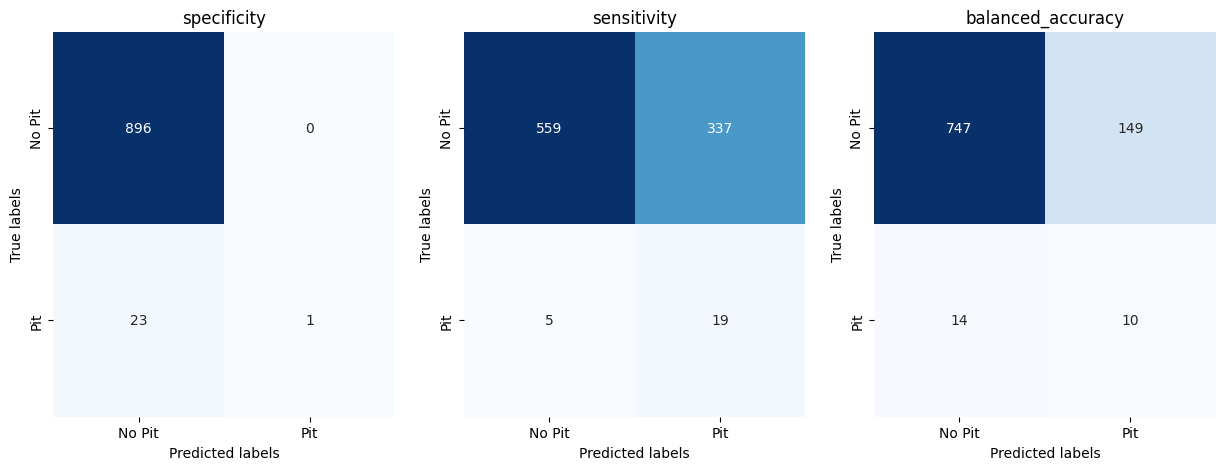

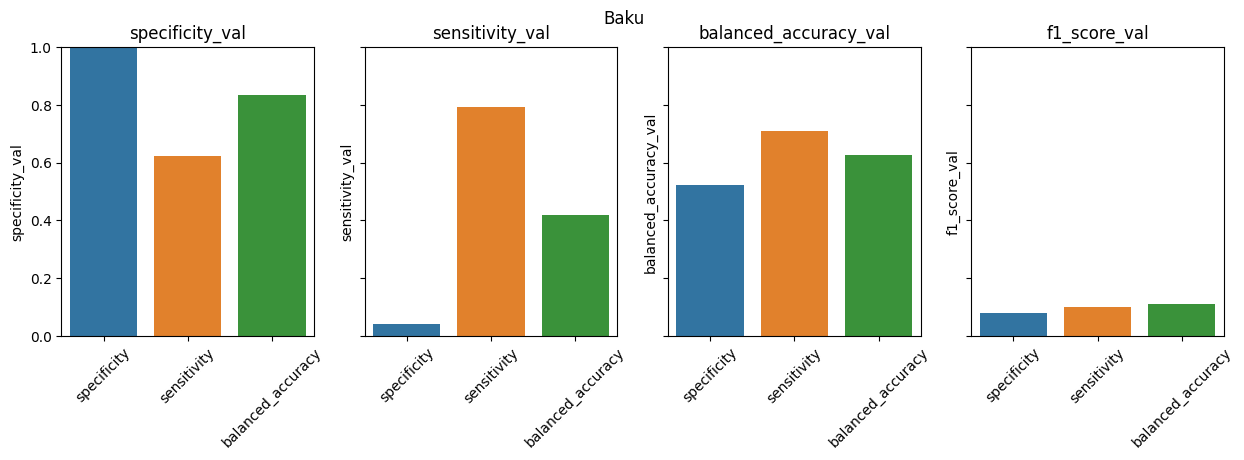

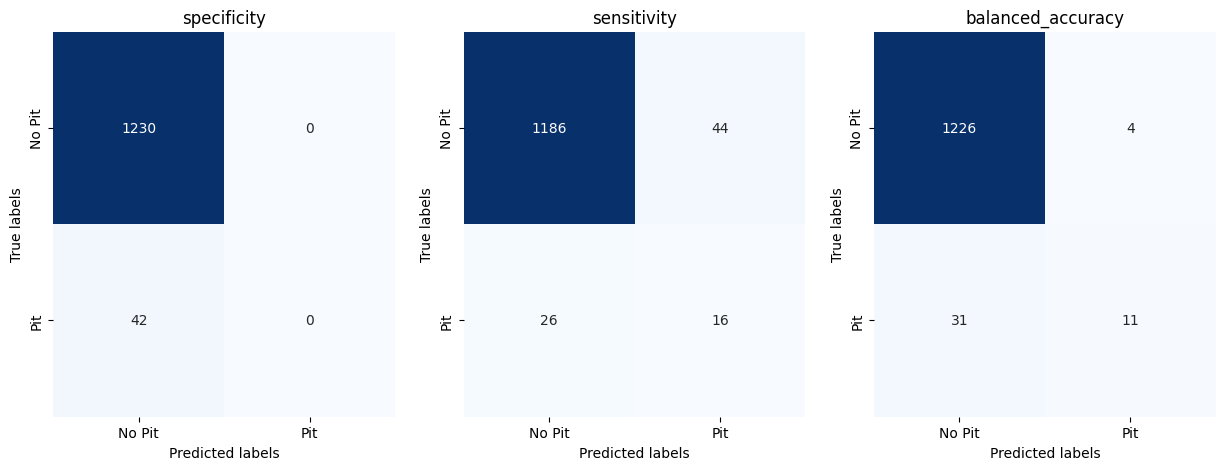

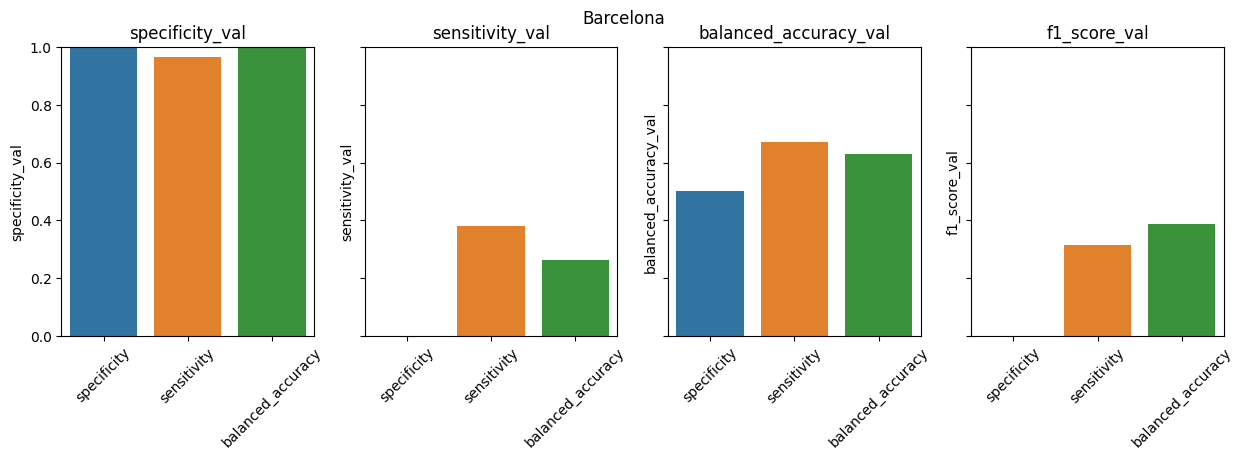

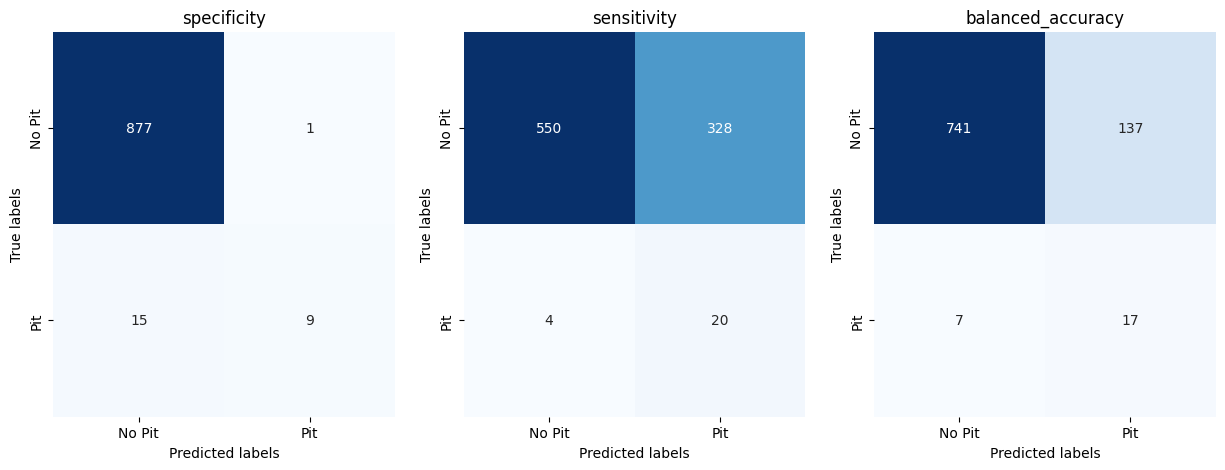

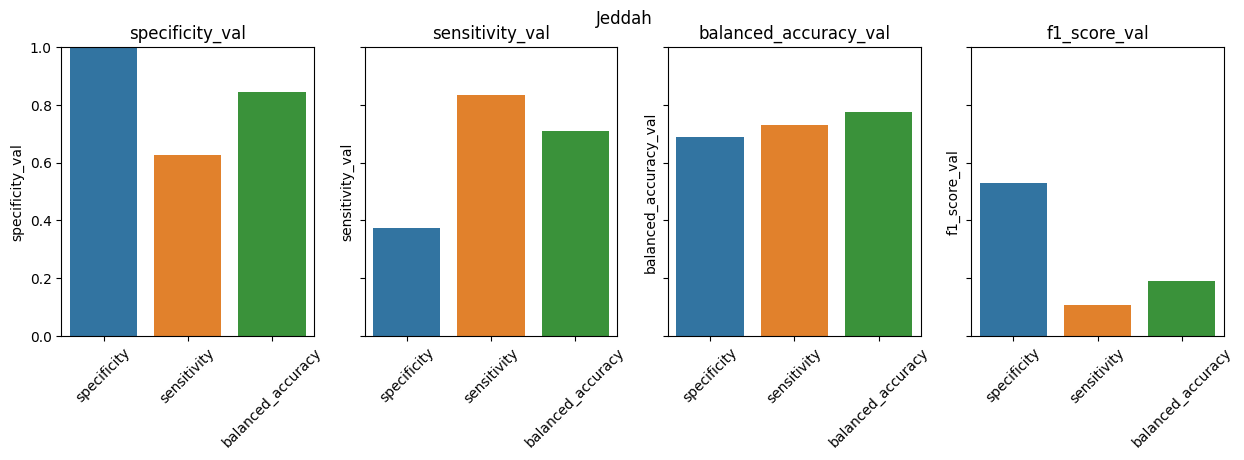

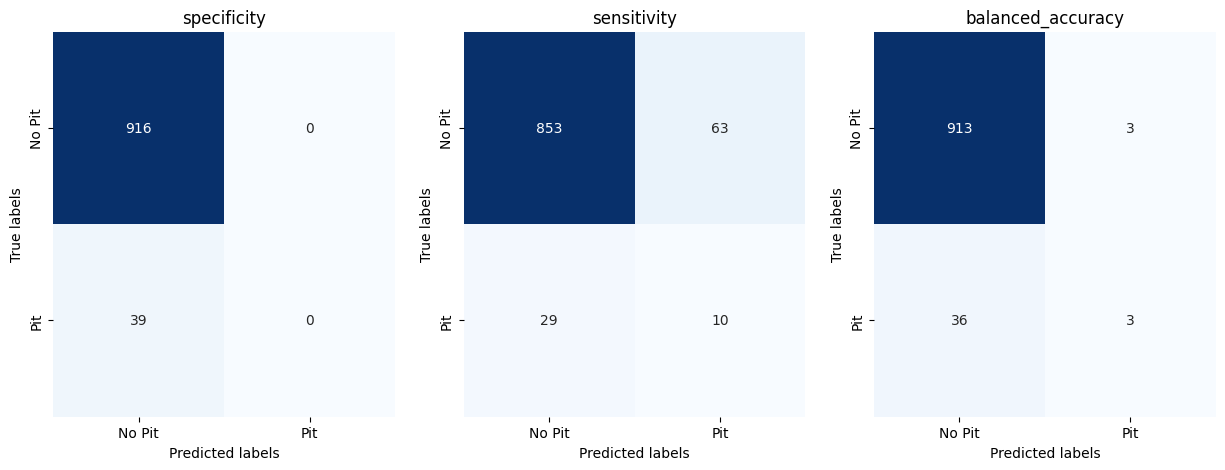

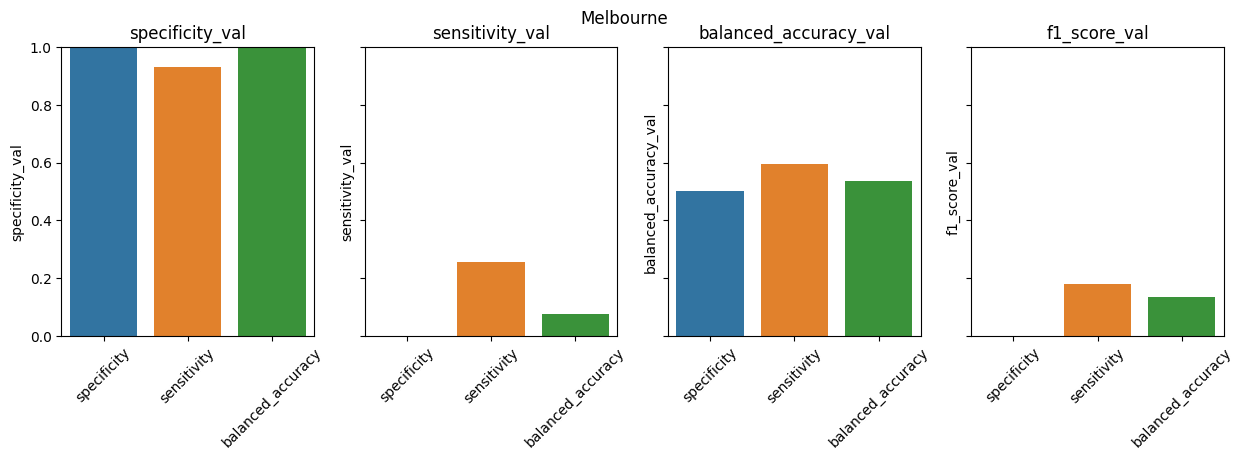

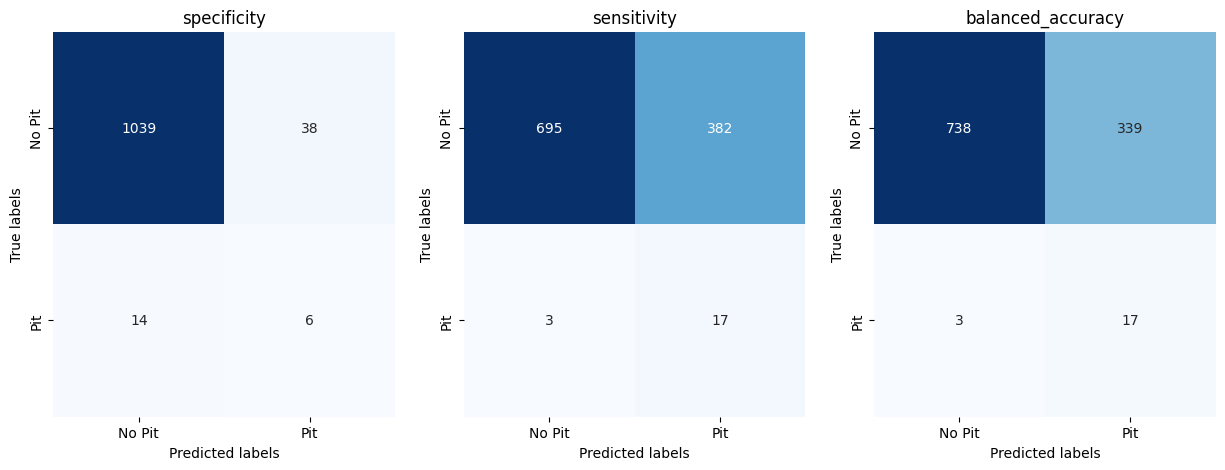

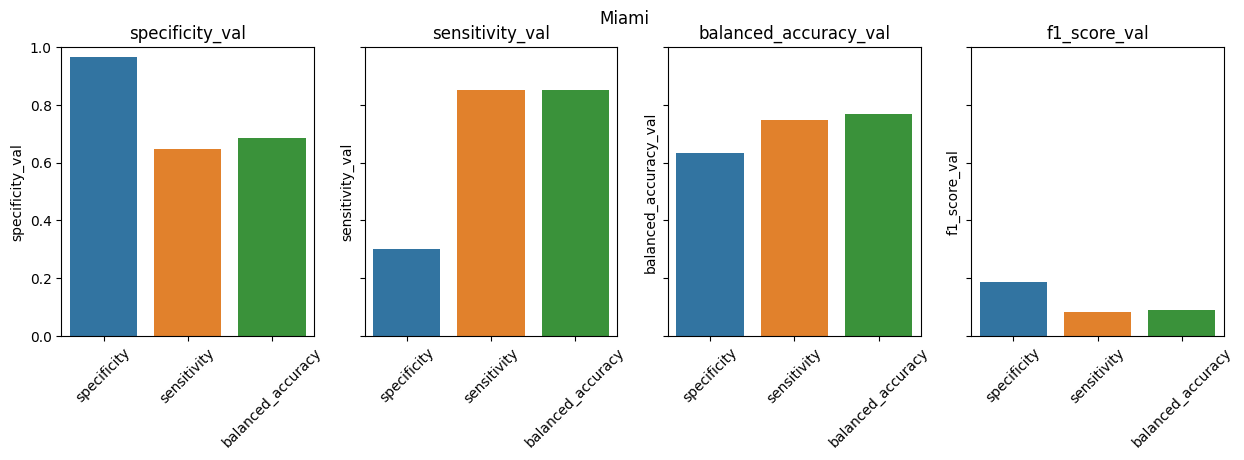

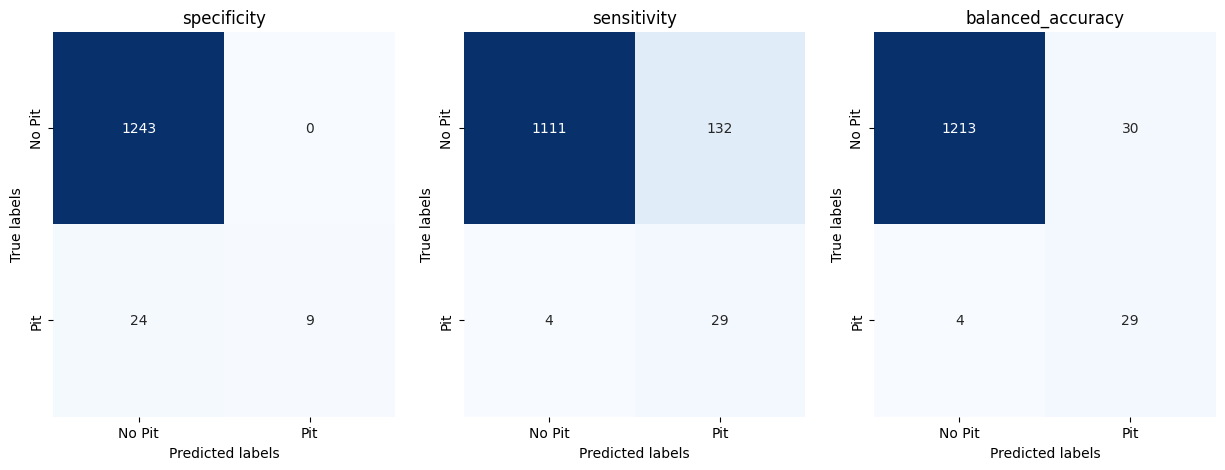

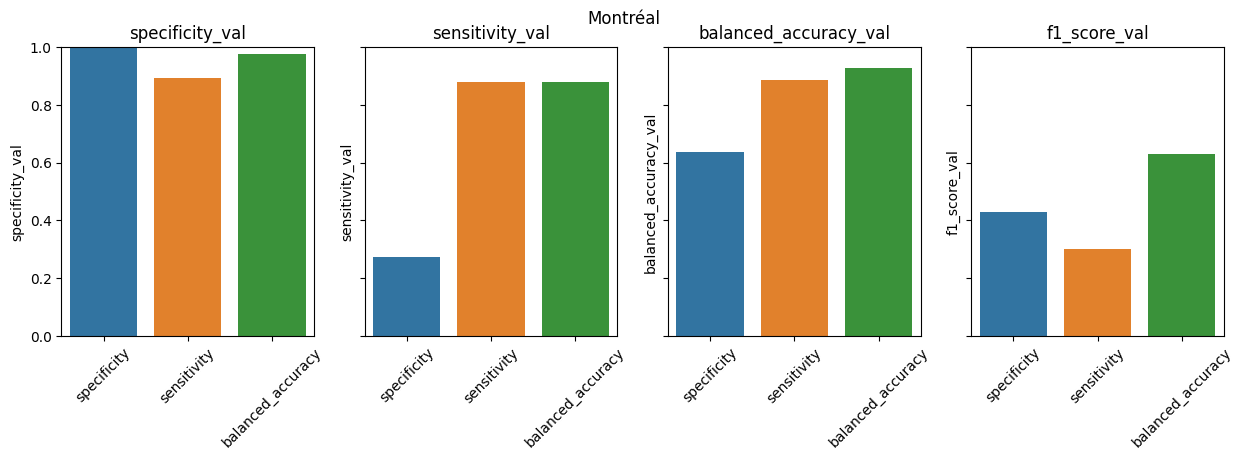

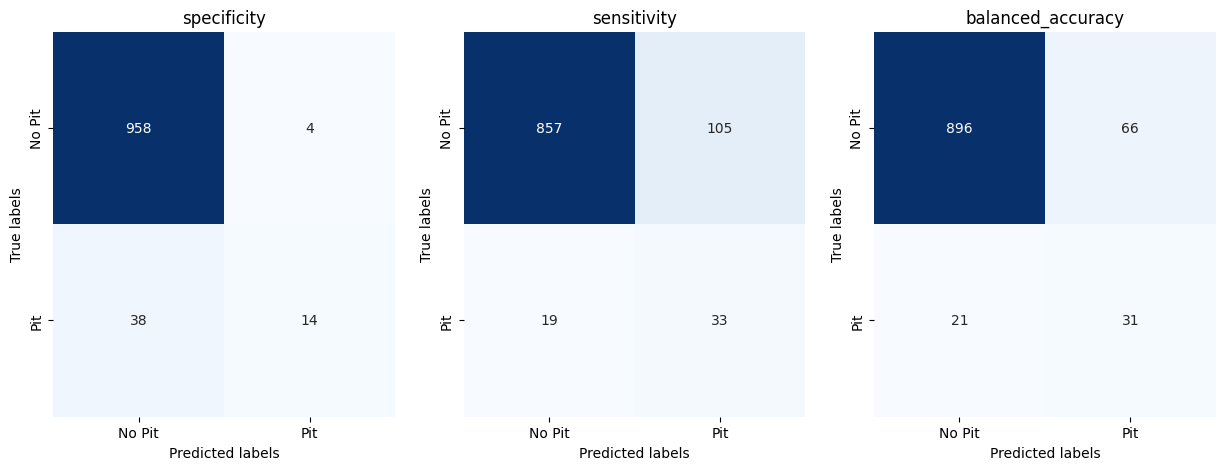

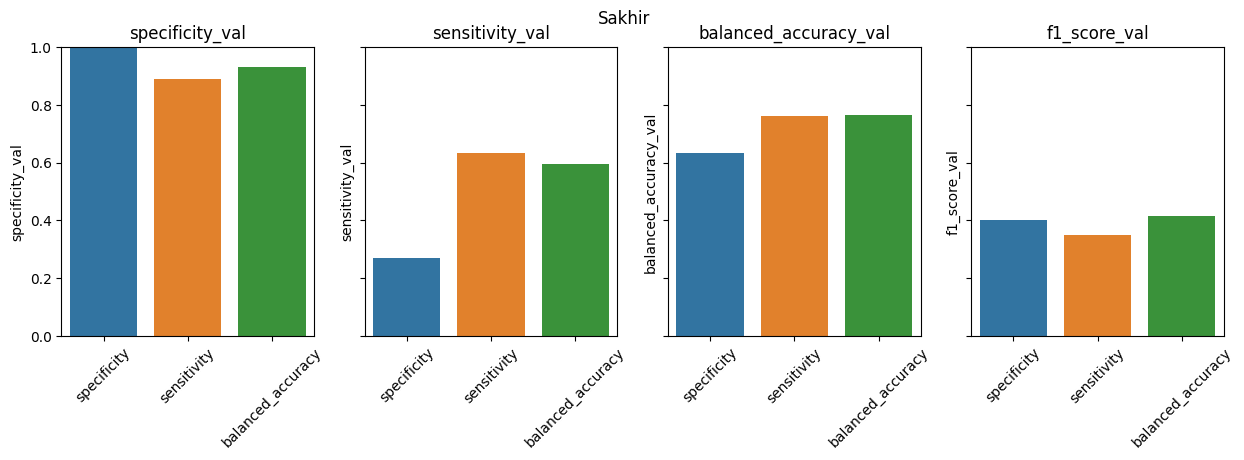

In [19]:
for track in laps_df.index:
    track_df = laps_df.loc[track]
    track = track[0]
    plot_consfusion_matrices(track_df['y'], track_df['preds'], save_path=os.path.join(figures_path, f'{track}_confusion_matrices.svg'))
    plot_metrics(get_metrics_df(models, track_df['x'], track_df['y']), save_path=os.path.join(figures_path, f'{track}_metrics.svg'))
    plt.suptitle(track)

In [182]:
def get_full_races_of_drivers(data, n):
    # Get n drivers who finished the race
    drivers_number = data.groupby(['Track', 'DriverNumber']).filter(
        lambda x: x['LapNumber'].max() == x['TotalLaps'].max()).groupby(['Track']).nth(list(range(n)))[['Track', 'DriverNumber']]
    # Get all laps of these drivers
    return pd.merge(drivers_number, data, on=['Track', 'DriverNumber'], how='left')

def get_predictions_for_race(model, race):
    x, y = get_preprocessed_data(race, encoder)
    return pd.Series({
                'Track' : race['Track'].unique()[0],
                'DriverNumber' : race['DriverNumber'].unique()[0],
                'x': x,
                'y': y,
                'preds': get_preds(model, x, proba=False),
                'proba': get_preds(model, x, proba=True),
            })

def get_predictions_for_races(model, races):
    return races.groupby(['Track', 'DriverNumber']).apply(lambda x: get_predictions_for_race(model, x)) 

In [204]:
def plot_remove_duplicate_legends(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), **kwargs)
    return ax

def plot_stoppages(laps, ax):
    ax.grid(True)
    for idx, lap in laps.iterrows():
        if lap['Red']:
            ax.axvspan(idx, idx+1, facecolor='red', alpha=0.3, zorder=0, label='Red Flag')
        elif lap['SC']:
            ax.axvspan(idx, idx+1, facecolor='yellow', alpha=0.3, zorder=0, label='Safety Car', hatch='\\', edgecolor='black')
        elif lap['VSC']:
            ax.axvspan(idx, idx+1, facecolor='yellow', alpha=0.3, zorder=0, label='Virtual Safety Car', hatch='-', edgecolor='black')
        elif lap['SC_ending']:
            ax.axvspan(idx, idx+1, facecolor='yellow', alpha=0.3, zorder=0, label='Safety Car Ending', hatch='\\', edgecolor='green')
        elif lap['Yellow']:
            ax.axvspan(idx, idx+1, facecolor='yellow', alpha=0.3, zorder=0, label='Yellow Flag')

    return plot_remove_duplicate_legends(ax, loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0.)

def plot_tyres(laps, ax):
    ax.grid(True)
    for idx, lap in laps.iterrows():
        if lap['Compound_HARD']:
            ax.axvspan(idx, idx+1, facecolor='red', alpha=1, zorder=-1, label='Soft', ymin=0.99)
            #ax.axhline(y=0.99, xmin=idx, xmax=idx+1, linewidth=1, color='red', zorder=0)
        elif lap['Compound_MEDIUM']:
            ax.axvspan(idx, idx+1, facecolor='yellow', alpha=1, zorder=-1, label='Medium', ymin=0.99)
            #ax.axhline(y=0.99, xmin=idx, xmax=idx+1, linewidth=1, color='yellow', zorder=0)
        elif lap['Compound_SOFT']:
            ax.axvspan(idx, idx+1, facecolor='grey', alpha=1, zorder=-1, label='Hard', ymin=0.99)
            #ax.axhline(y=0.99, xmin=idx, xmax=idx+1, linewidth=1, color='grey', zorder=0)
        elif lap['Compound_INTERMEDIATE']:
            ax.axvspan(idx, idx+1, facecolor='green', alpha=1, zorder=-1, label='Intermediate', ymin=0.9)
            #ax.axhline(y=0.99, xmin=idx, xmax=idx+1, linewidth=1, color='green', zorder=0)
        elif lap['Compound_WET']:
            ax.axvspan(idx, idx+1, facecolor='blue', alpha=1, zorder=-1, label='Wet', ymin=0.99)
            #ax.axhline(y=0.99, xmin=idx, xmax=idx+1, linewidth=1, color='blue', zorder=0)

    return plot_remove_duplicate_legends(ax, loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0.)

def plot_race_predictions(label, track, driver, x, y, proba, ax, color='cyan', marker='X'):
    ax.grid(True)
    ax.hlines(y=0.5, xmin=0, xmax=x['TotalLaps'].max(), linewidth=1, colors='black', linestyles='dotted', zorder=0)
    indexes = np.where(y == 1)
    for idx in indexes:
        ax.vlines(x=idx+2, ymin=0, ymax=1, linewidth=1, colors='red', linestyles='dashed', zorder=0)
    sns.scatterplot(x=x['LapNumber'], y=proba, marker=marker, legend=False, ax=ax, s=50, label=label)
    sns.lineplot(x=x['LapNumber'], y=proba, linewidth=1, linestyle='dashed', zorder=0, ax=ax)
    ax.set_xlabel('Lap Number')
    ax.set_xticks(np.arange(0, x['TotalLaps'].max(), 5))
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability of pitting')
    ax.set_xlim(0, x['TotalLaps'].max())    

    ax.set_title(f'{track} - Driver {driver}')
    return plot_remove_duplicate_legends(ax, loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [192]:
from math import ceil
def plot_models_performance(models, data, drivers_per_race, max_per_col=3, save_path=None):
    preds = {}
    race_data = get_full_races_of_drivers(data, drivers_per_race)
    for name, model in models.items():
        preds_df = get_predictions_for_races(model, race_data)
        preds[name] = preds_df
    
    for no_track in range(len(race_data['Track'].unique())):
        ncols = max_per_col if drivers_per_race > max_per_col else drivers_per_race
        nrows = ceil(drivers_per_race / ncols)
        fig, axes = plt.subplots(figsize=(10 * ncols, 7 * nrows), ncols=ncols, nrows=nrows, sharey=True)
        for no_driver, ax in enumerate(axes.flatten()):
            if no_driver > drivers_per_race - 1:
                ax.set_visible(False)
                continue
            for no_model, model in enumerate(preds):
                i = no_driver + no_track * drivers_per_race
                preds_df = preds[model]
                if no_model == 0:
                    ax = plot_stoppages(preds_df['x'][i], ax)
                    ax = plot_tyres(preds_df['x'][i], ax)
                ax = plot_race_predictions(model, preds_df['Track'][i], preds_df['DriverNumber'][i], preds_df['x'][i], preds_df['y'][i], preds_df['proba'][i], ax)
        plt.tight_layout()
        if save_path:
            plt.savefig(f'{save_path}/predictions_{no_track}.svg', bbox_inches='tight', format='svg')
        plt.show()

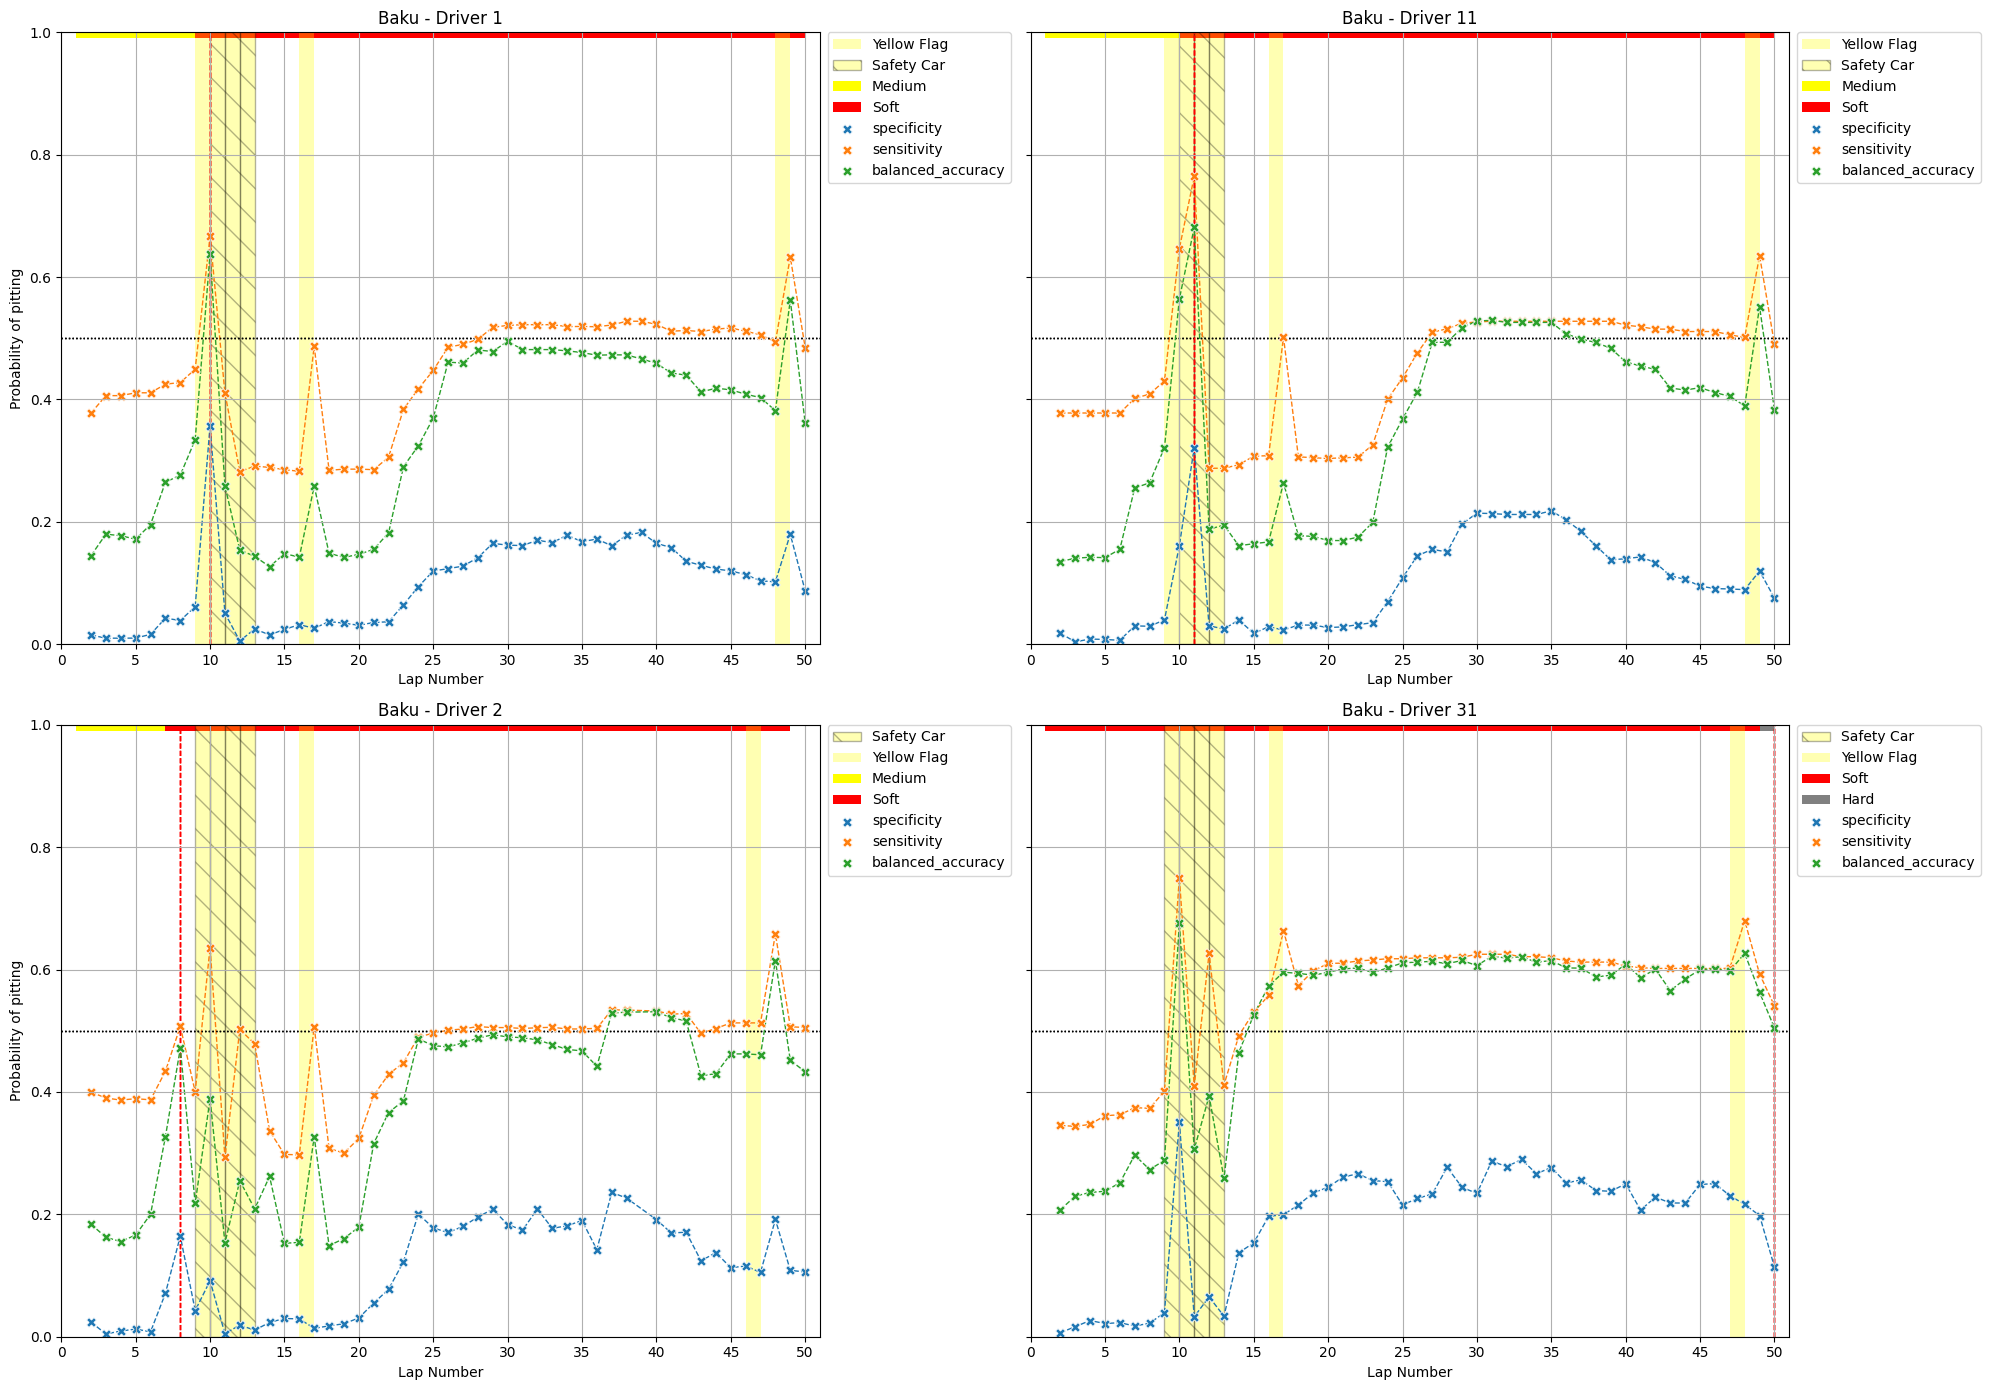

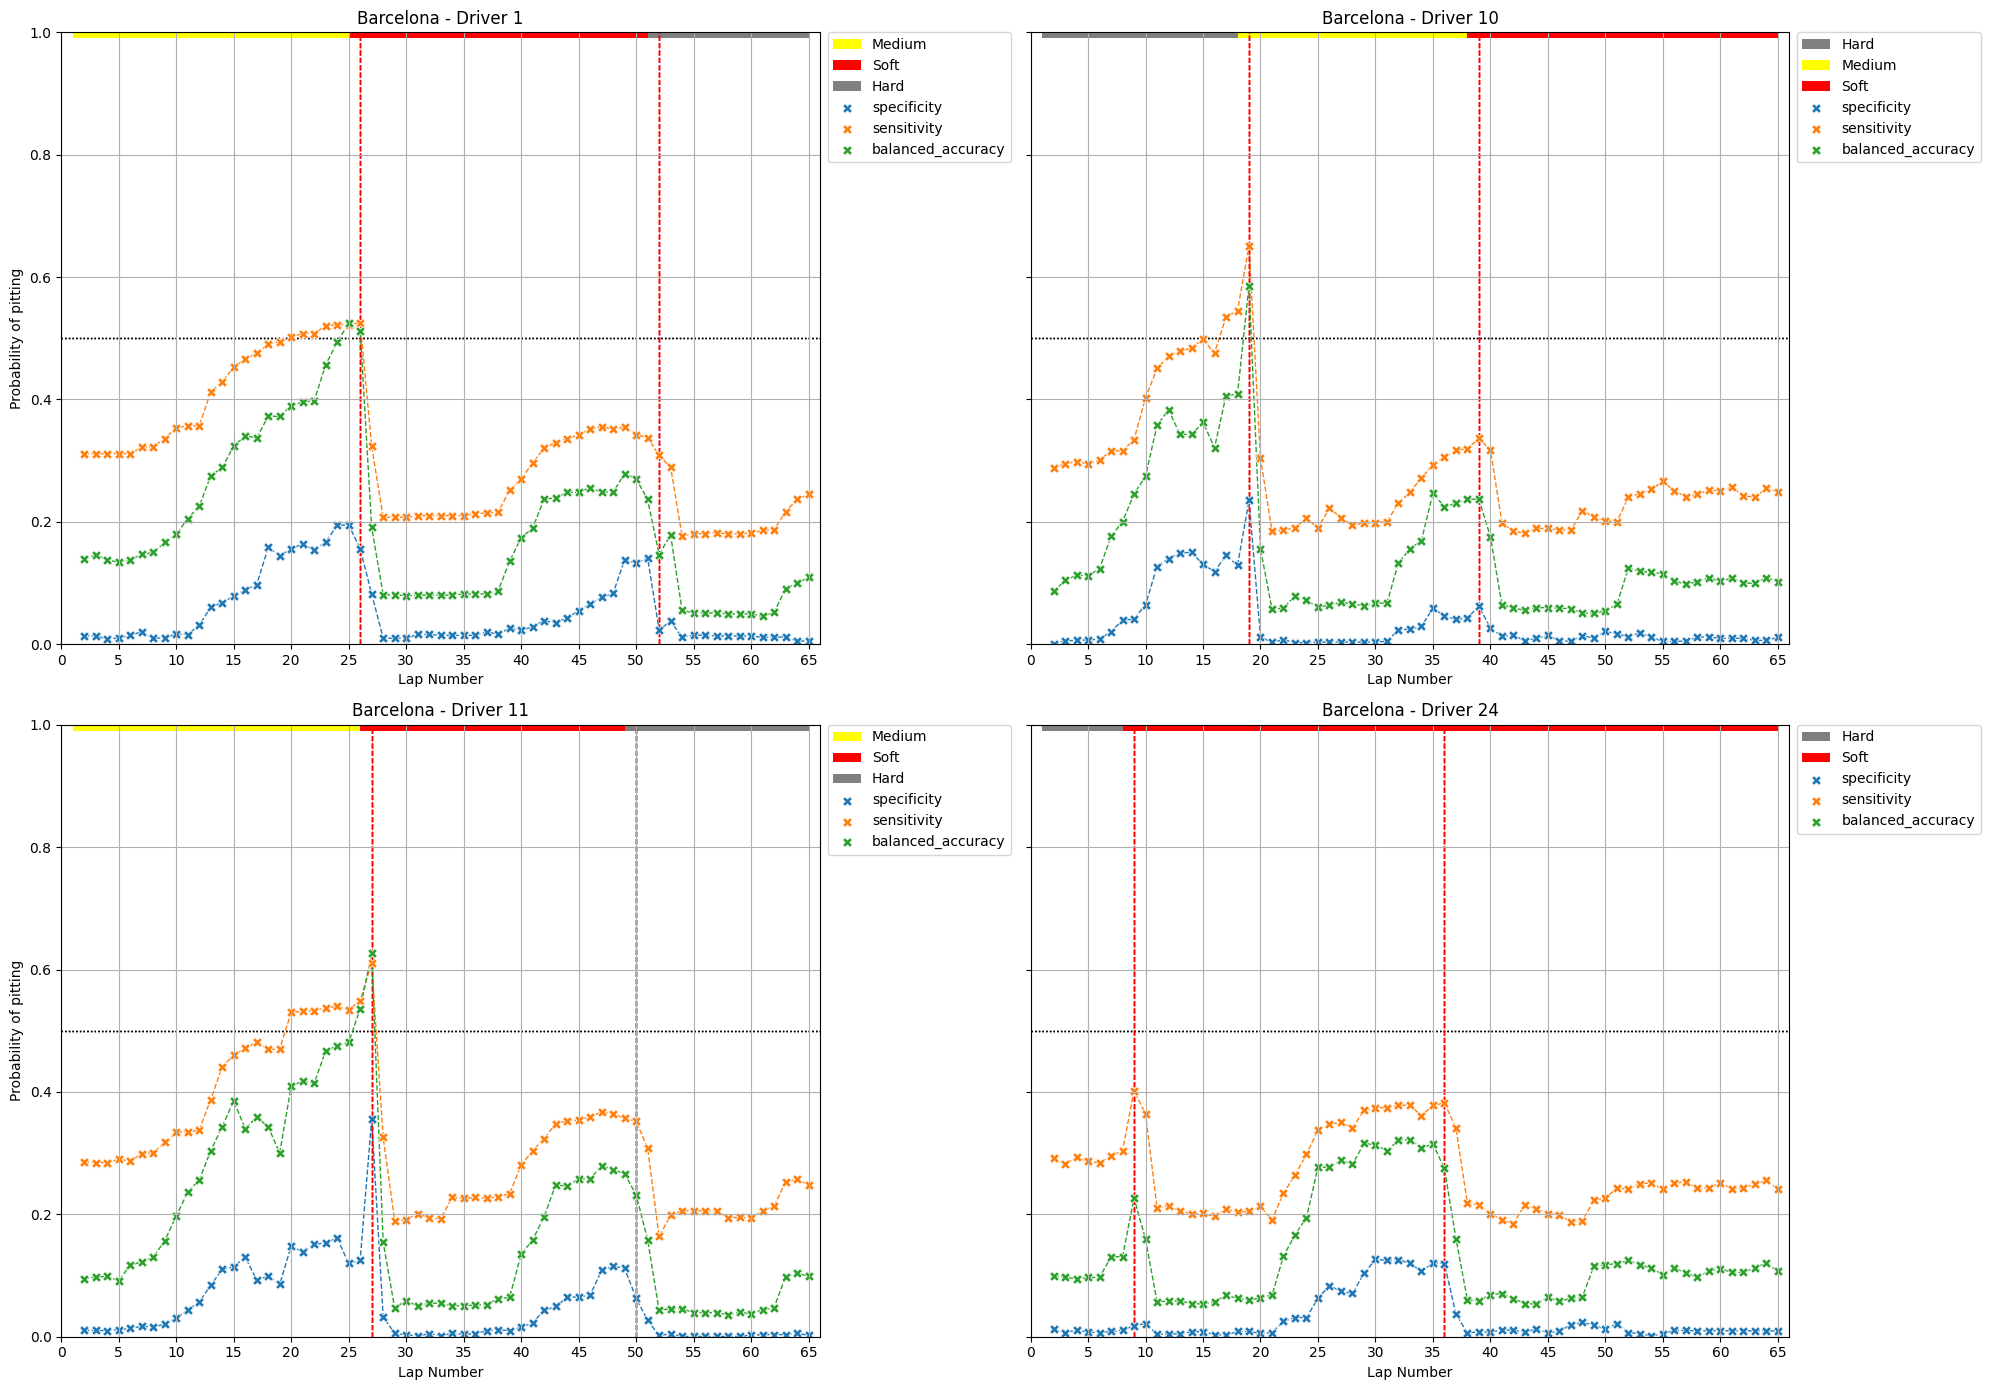

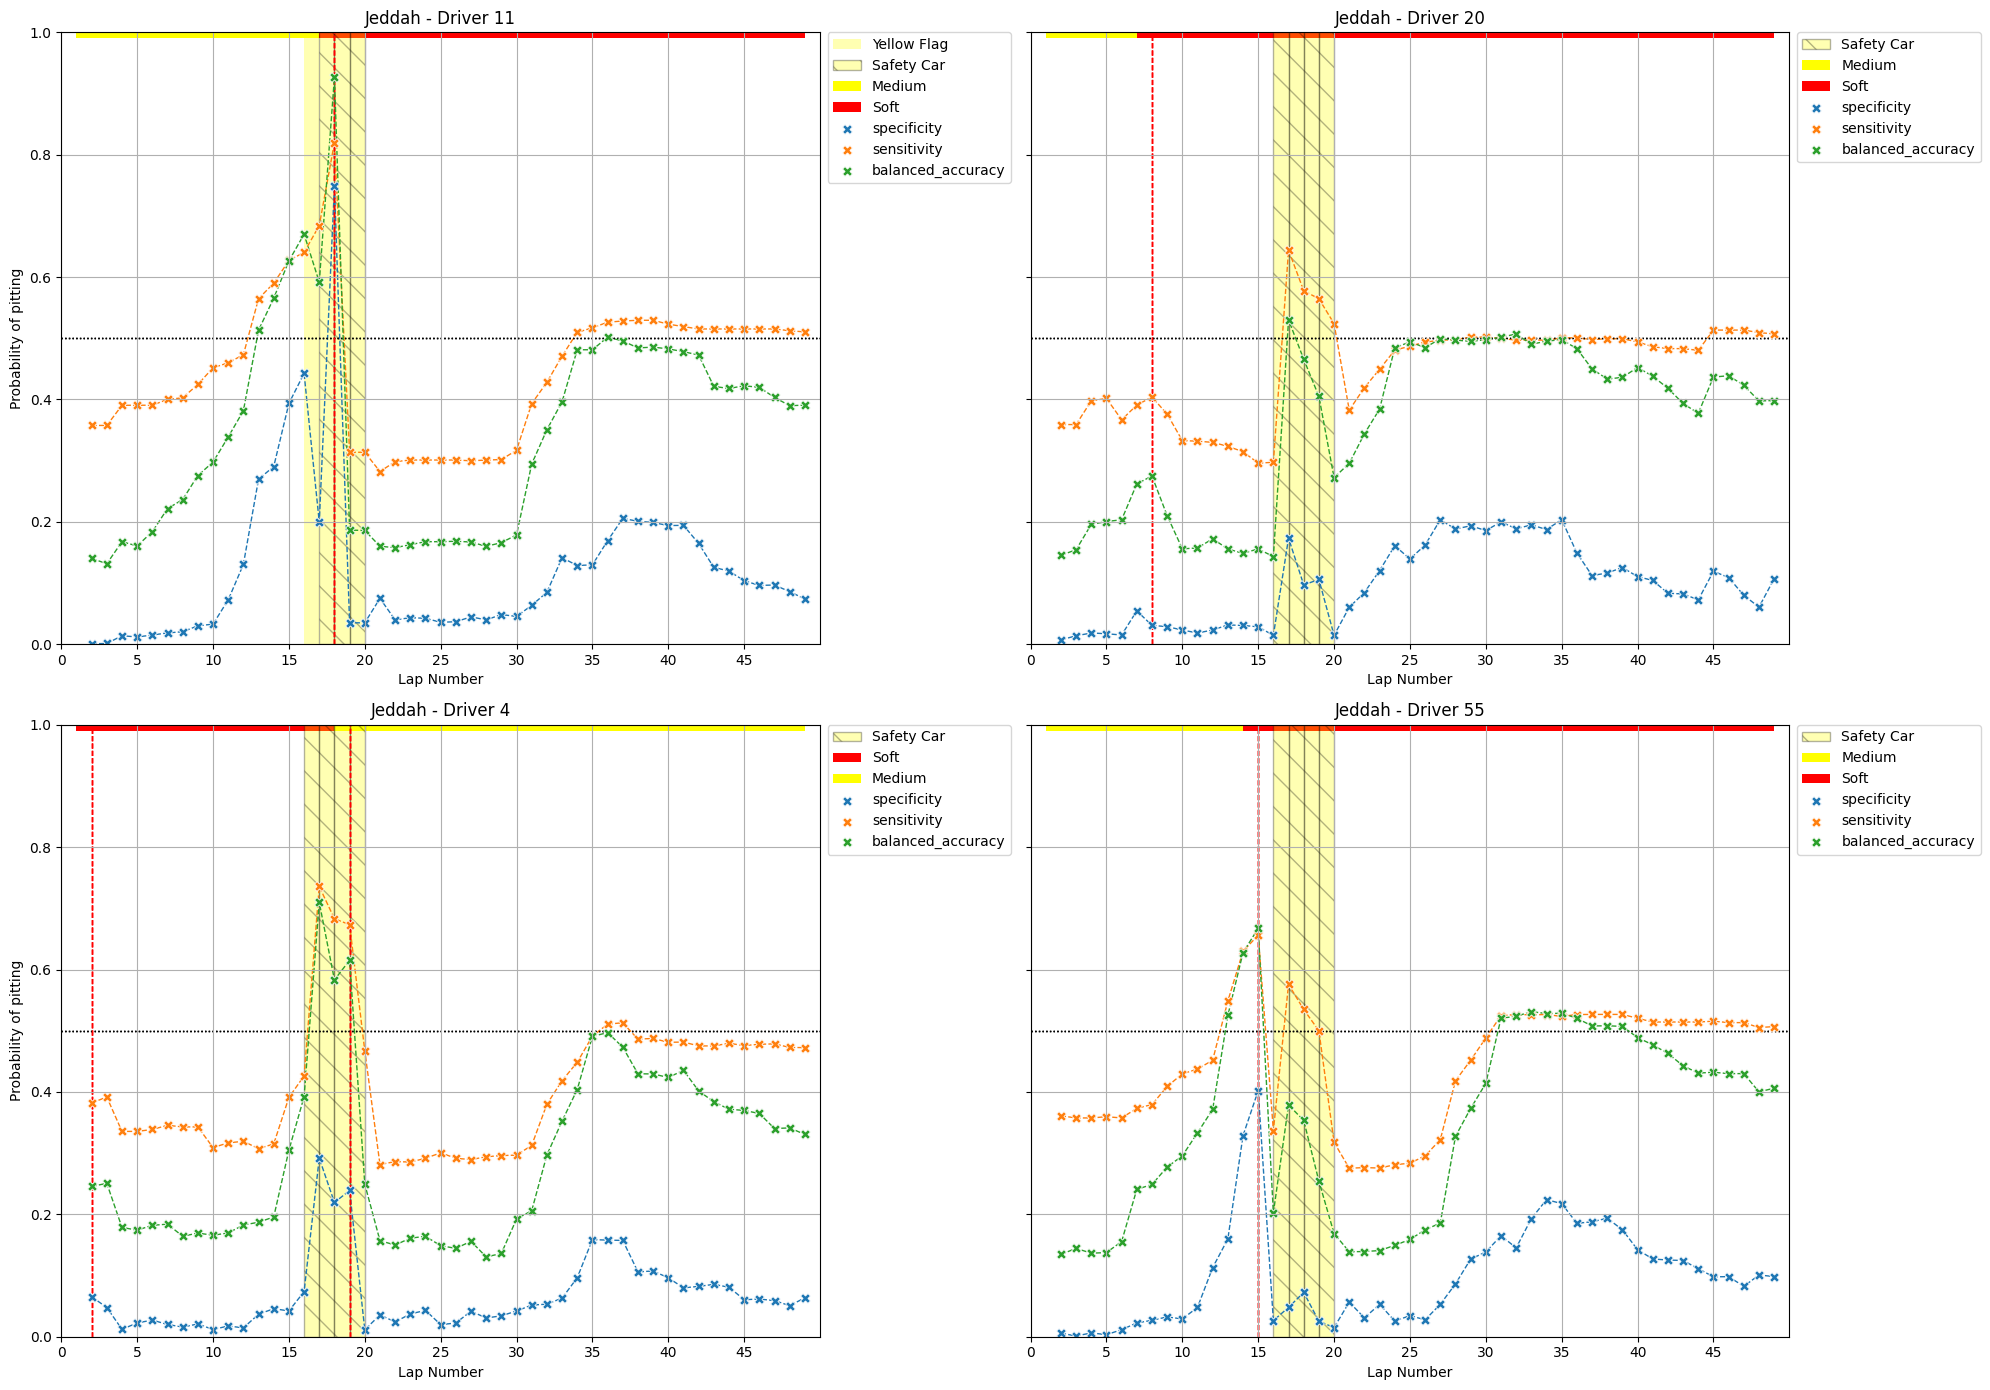

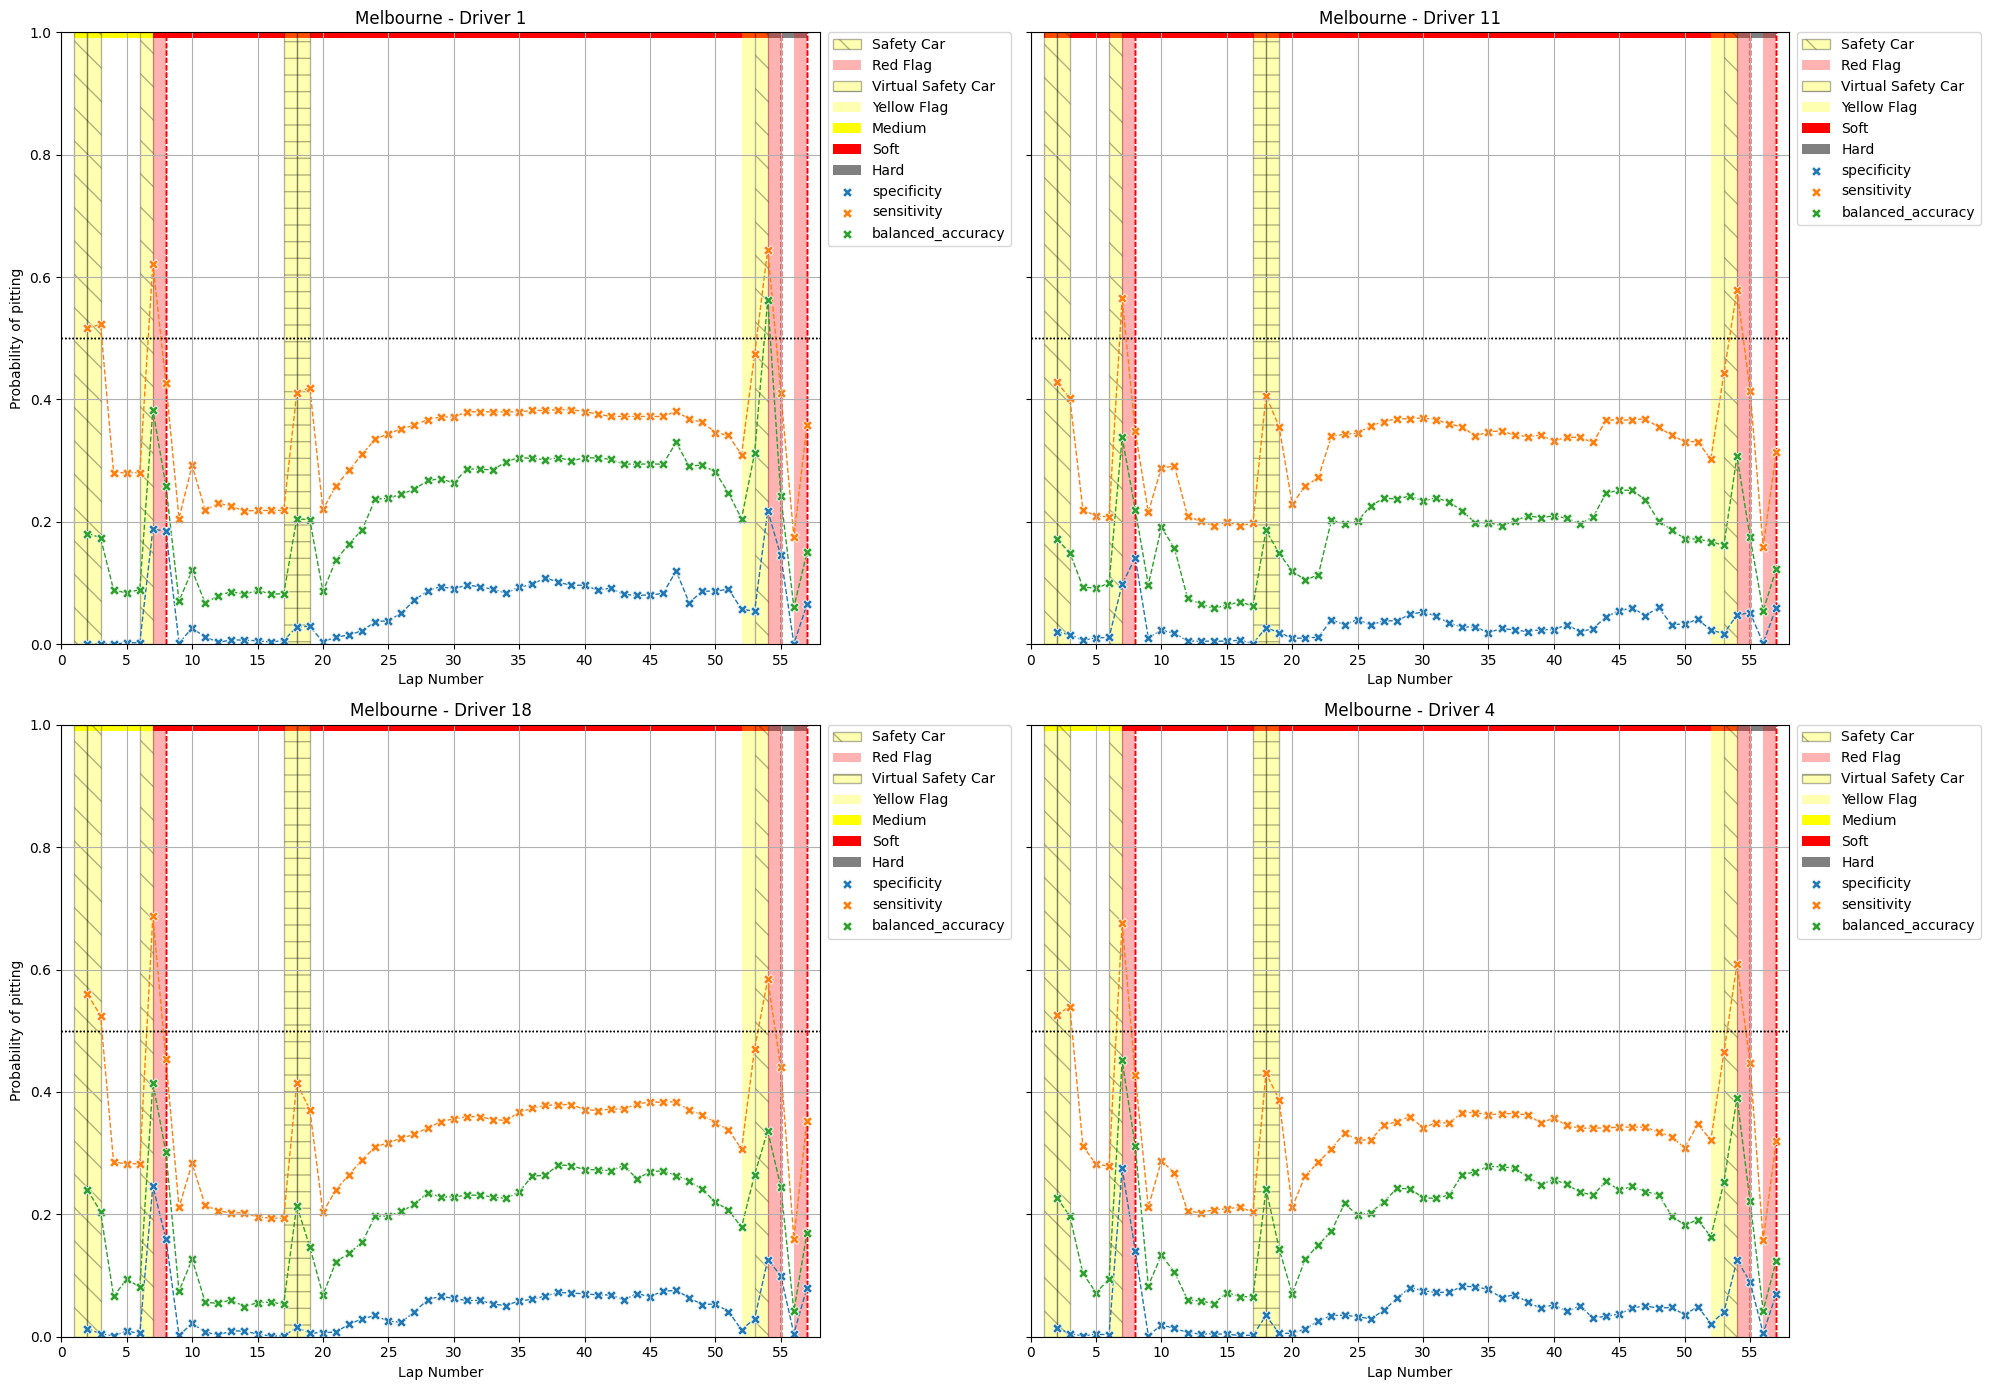

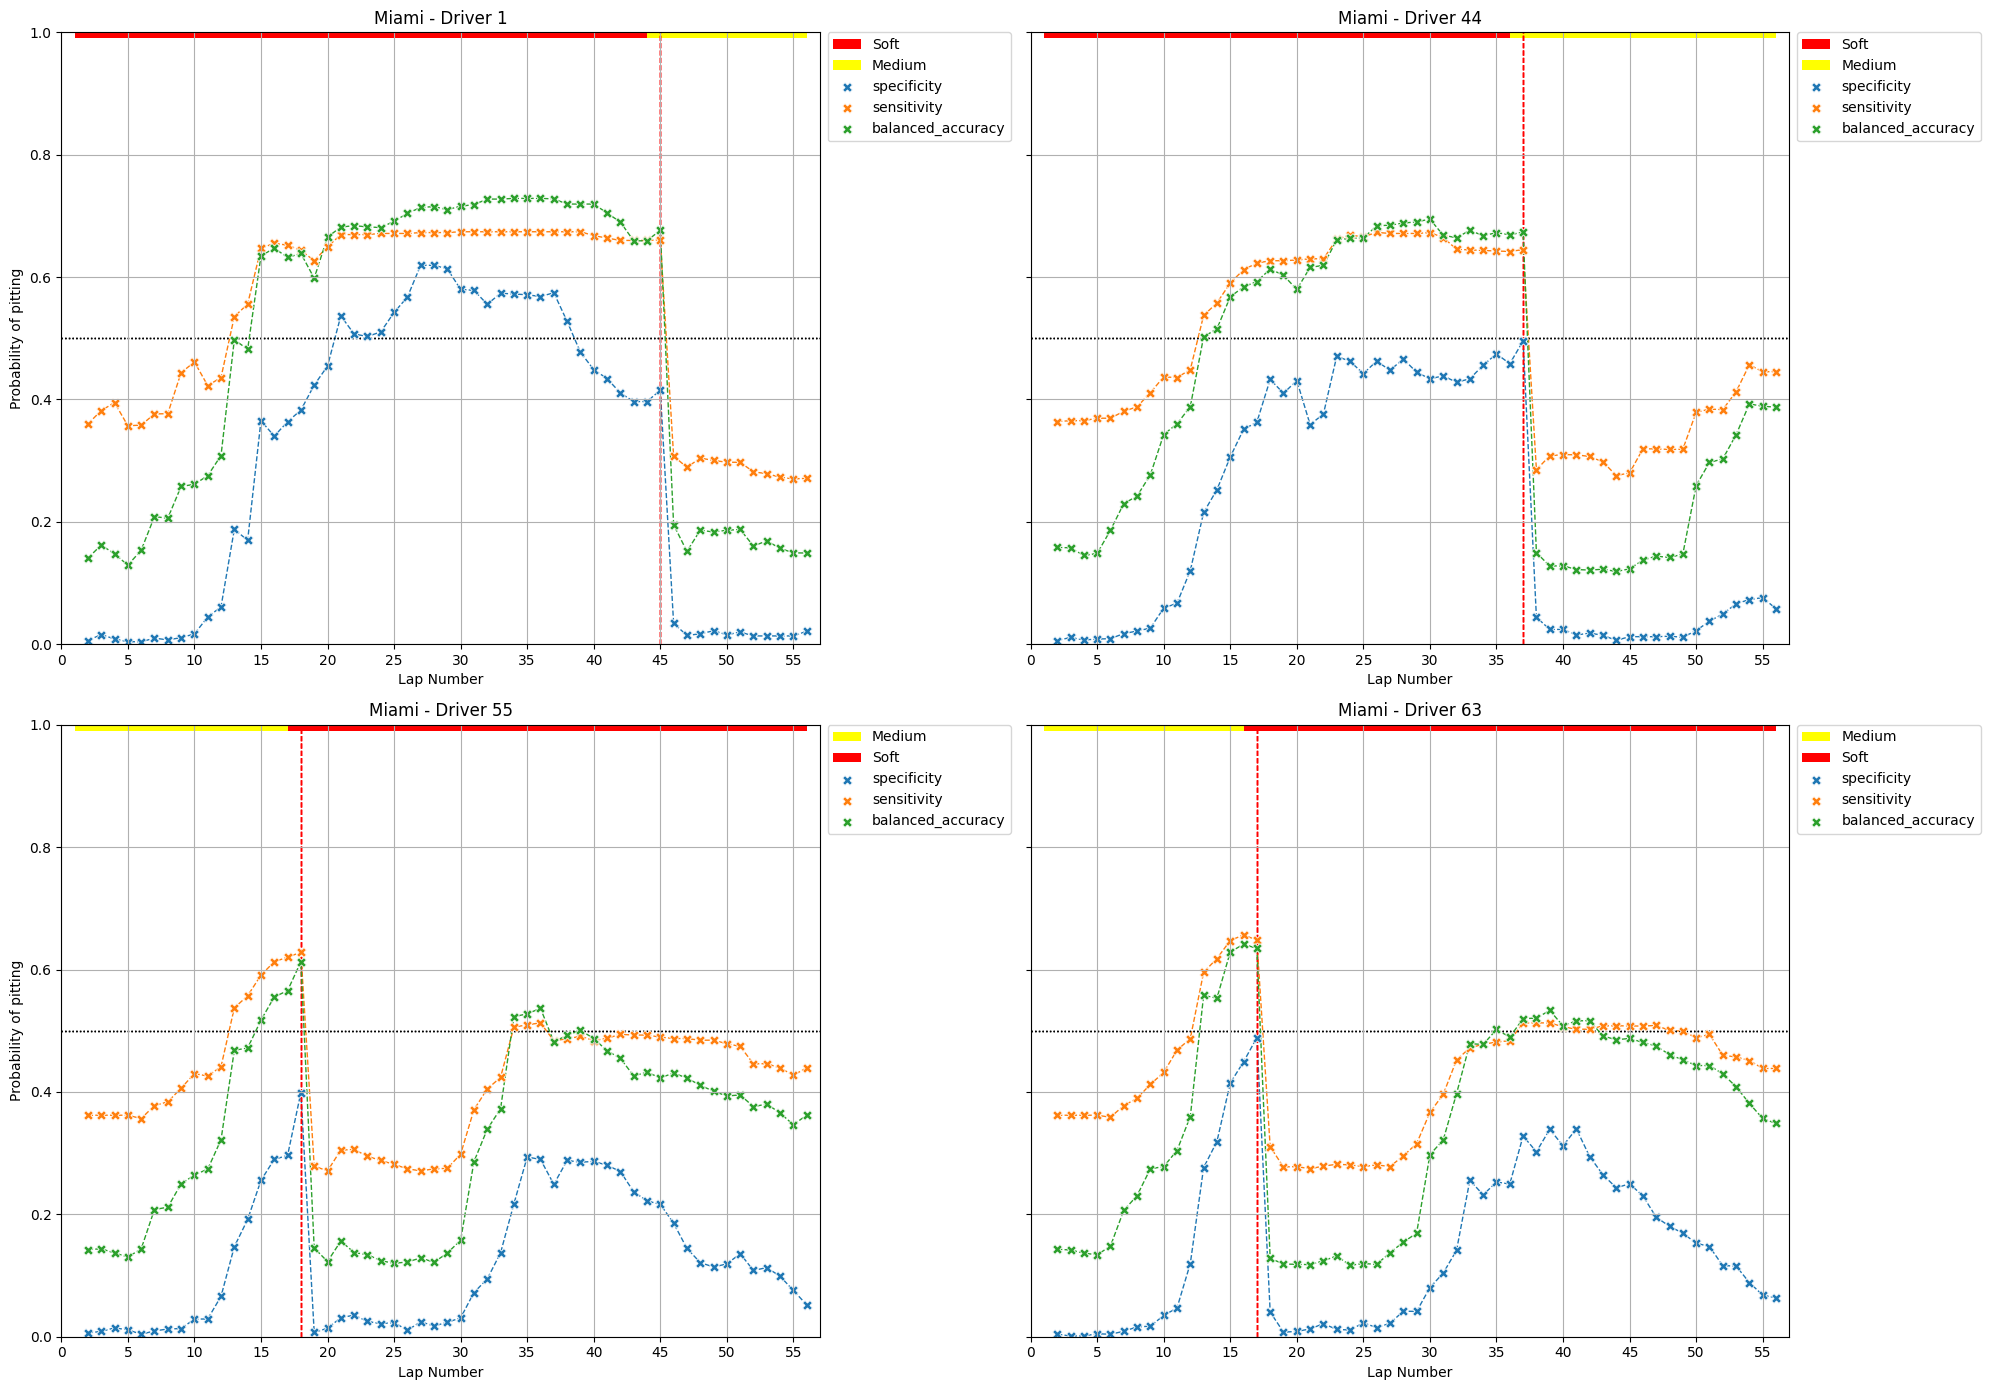

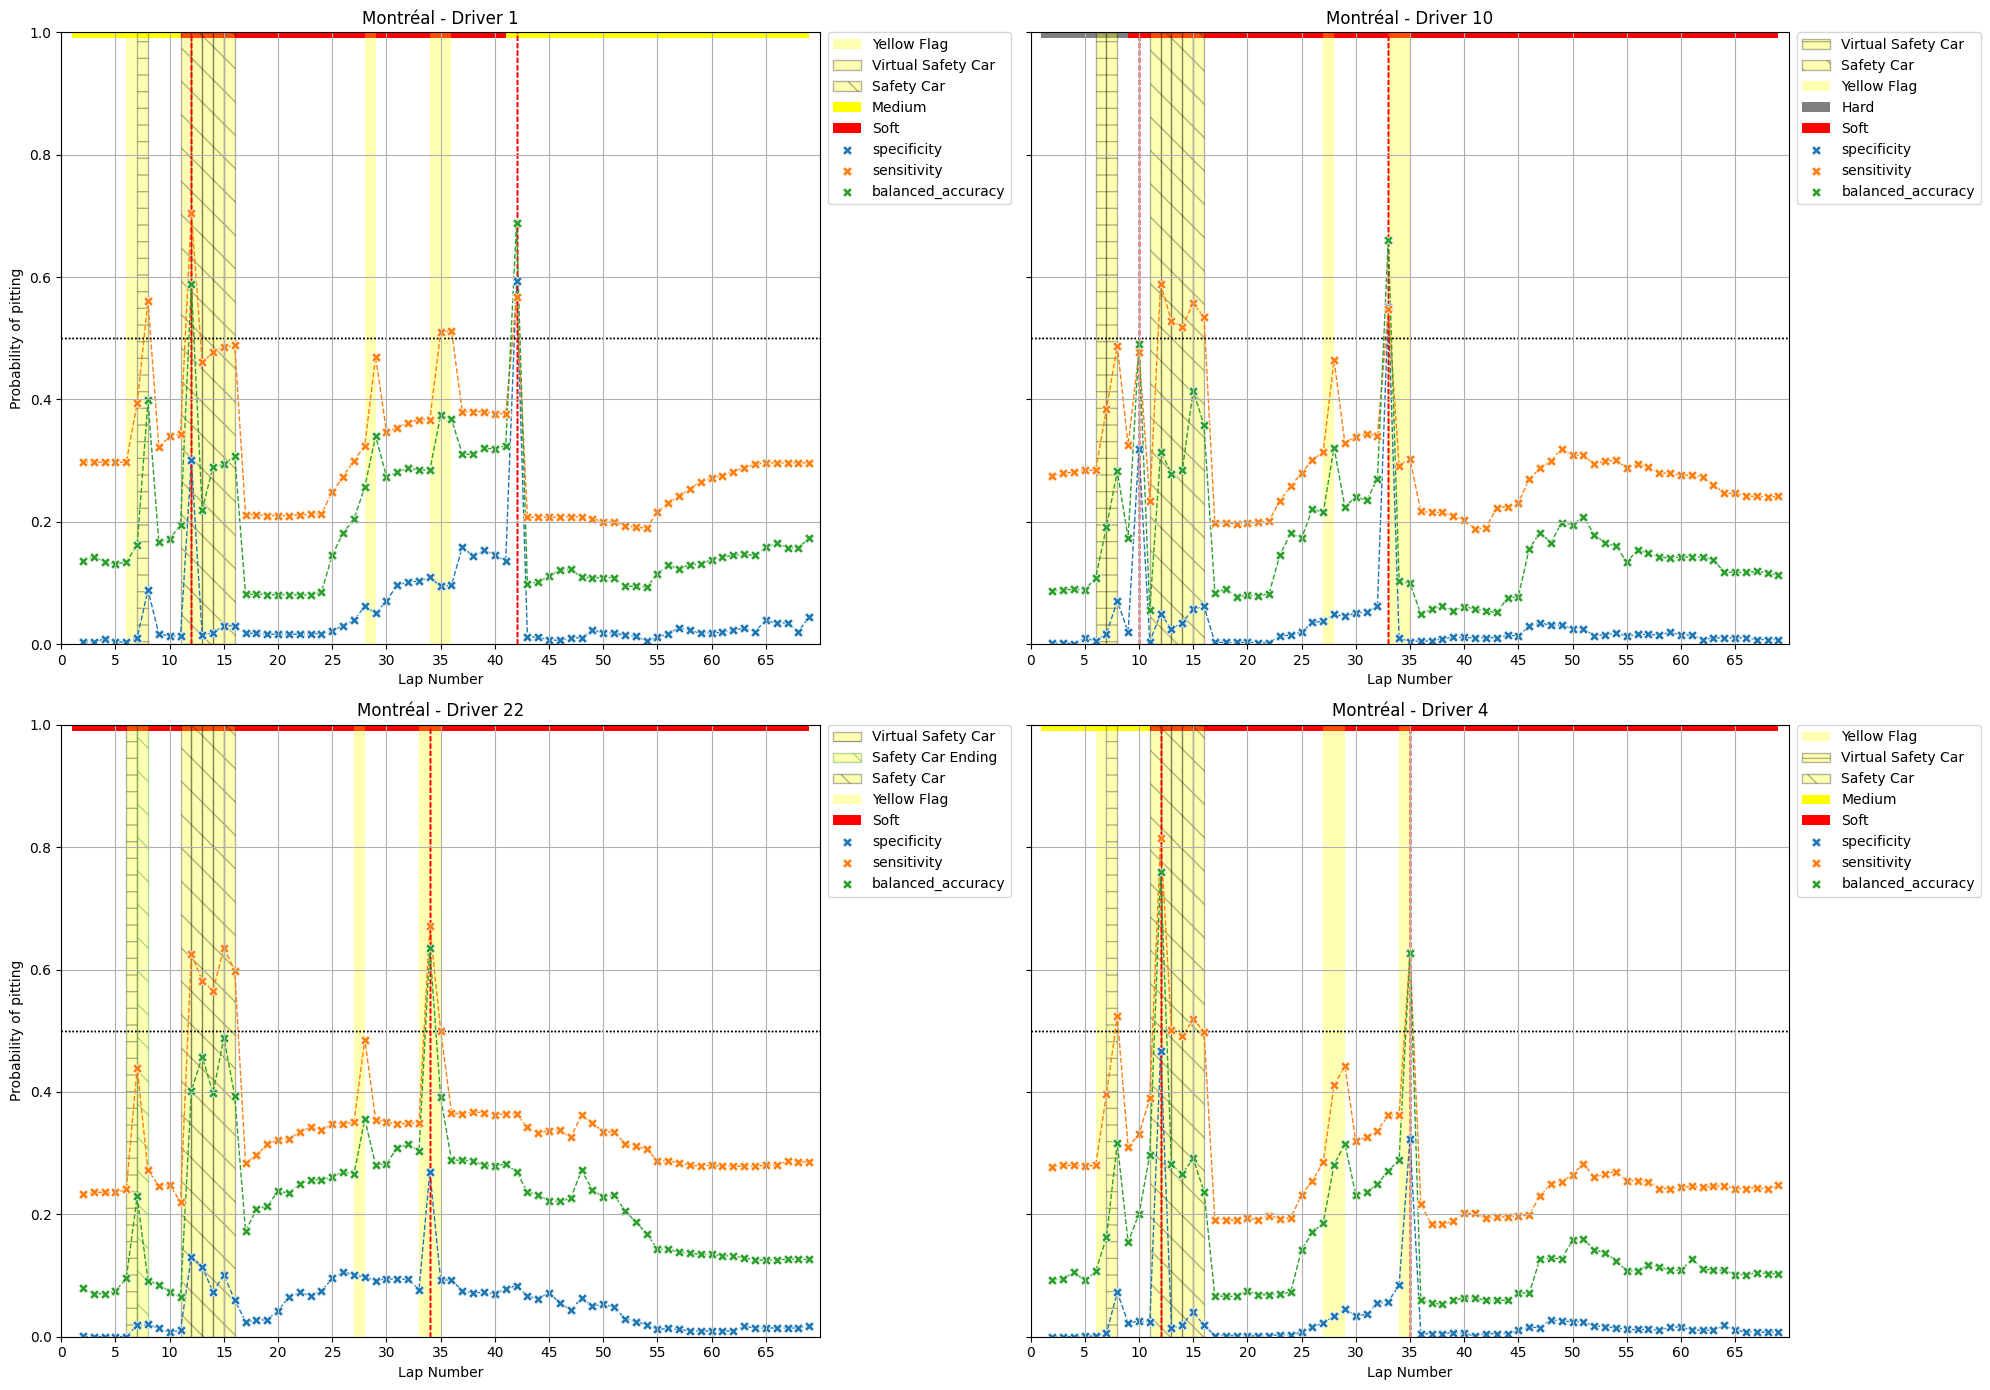

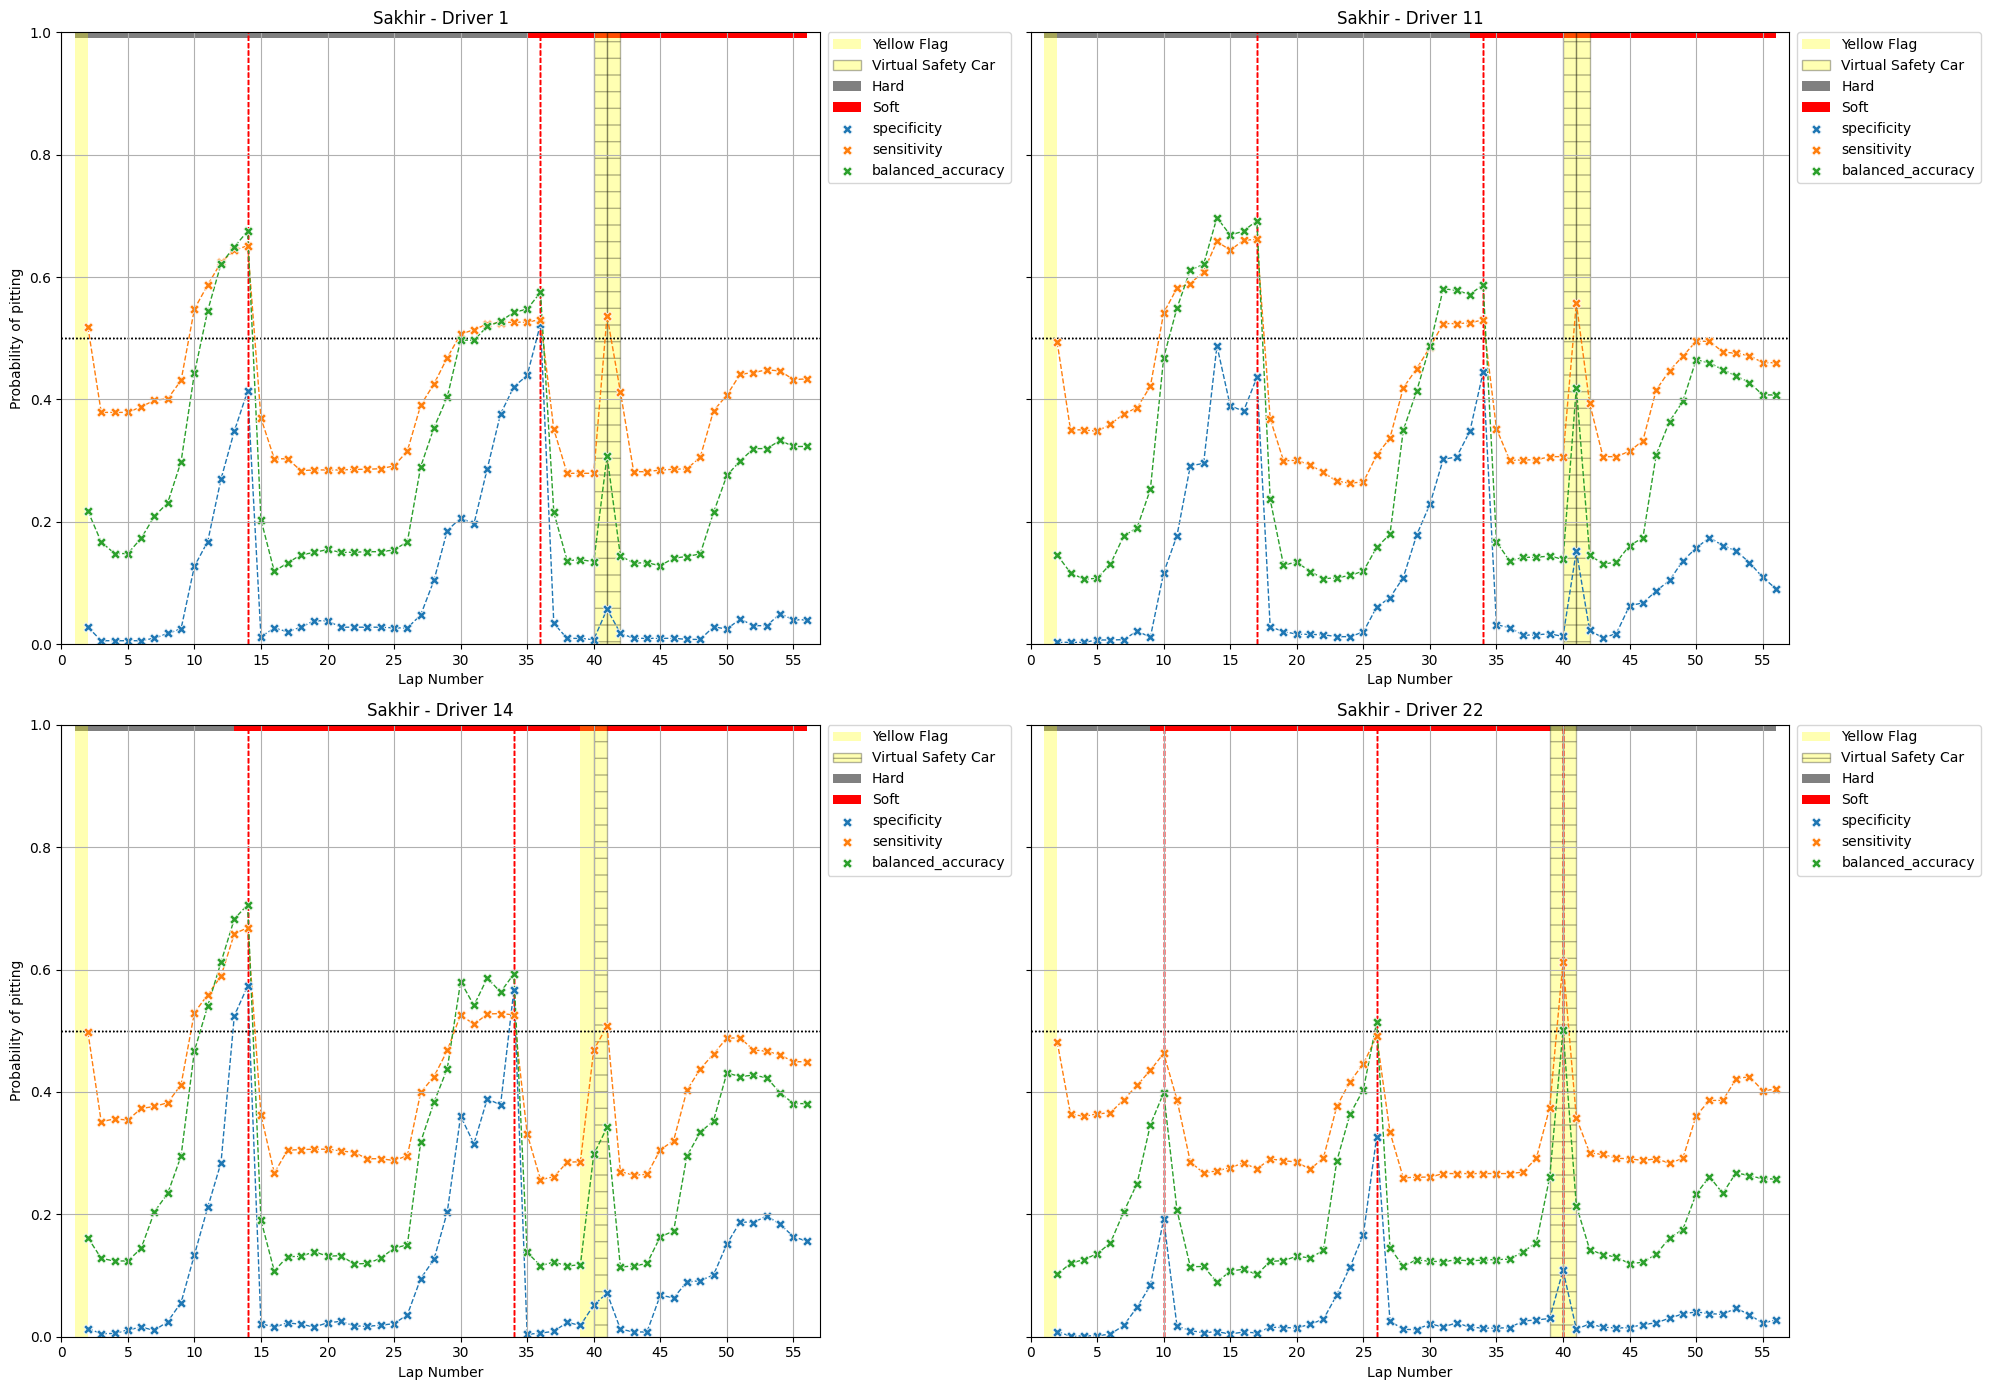

In [205]:
plot_models_performance(models, data, 4, max_per_col=2, save_path=figures_path)

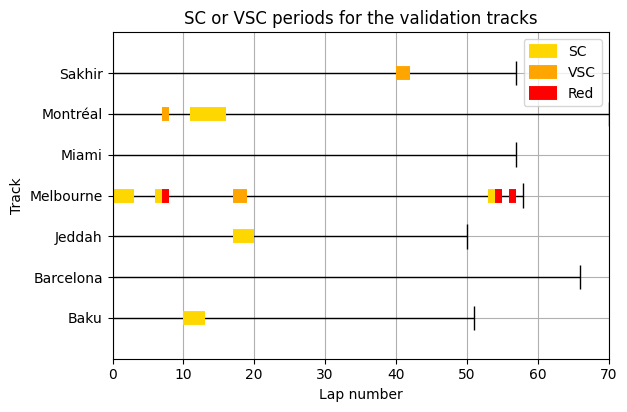

In [186]:
# Get the driver number of a driver who finished the race
drivers_number = data.groupby(['Track', 'DriverNumber']).filter(
    lambda x: x['LapNumber'].max() == x['TotalLaps'].max()
).groupby(['Track']).first()['DriverNumber']

import numpy as np

def findones(a):
    isone = np.concatenate(([0], a, [0]))
    absdiff = np.abs(np.diff(isone))
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return np.clip(ranges, 0, len(a) - 1)

def plotbooleans(ax, dictofbool, colors, label, lap_lines=False):
    ax.set_ylim([-1, len(dictofbool)])
    ax.set_yticks(np.arange(len(dictofbool.keys())))
    ax.set_yticklabels(dictofbool.keys())
    ax.set_xlim([0, max([len(x) for x in dictofbool.values()])])

    for i, (key, value) in enumerate(dictofbool.items()):
        indexes = findones(value)
        # create a vertical line for the last lap
        if lap_lines:
            ax.vlines(x=len(value), ymin=i-0.3, ymax=i+0.3, linewidth=1, colors='k')
            ax.hlines(y=i, xmin=0, xmax=len(value), linewidth=1, colors='k')

        for i2, idx in enumerate(indexes):
            if idx[0] == idx[1]:
                idx[1] = idx[1]+1
            if i+i2 == 0: # add label
                ax.hlines(y=i, xmin=idx[0], xmax=idx[1], linewidth=10, colors=colors, label=label)
            else:
                ax.hlines(y=i, xmin=idx[0], xmax=idx[1], linewidth=10, colors=colors, label=label)
    return plot_remove_duplicate_legends(ax)

fig, ax = plt.subplots()
plot_data_sc = {}
plot_data_vsc = {}
plot_data_red = {}
for track, driver_number in drivers_number.items():
    laps_of_driver = data.groupby(['Track', 'DriverNumber']).get_group((track, driver_number))
    stoppage = process_trackStatus(laps_of_driver)[['SC', 'VSC', 'Red']]
    #sc_or_vsc = [True if sc == True or vsc == True else False for sc, vsc in sc_vsc.values]
    plot_data_sc[track] = stoppage['SC'].values
    plot_data_vsc[track] = stoppage['VSC'].values
    plot_data_red[track] = stoppage['Red'].values
    
plotbooleans(ax, plot_data_sc, 'gold', 'SC', lap_lines=True)
plotbooleans(ax, plot_data_vsc, 'orange', 'VSC')
plotbooleans(ax, plot_data_red, 'red', 'Red')
plt.grid()
plt.subplots_adjust(bottom=0.2)
plt.title('SC or VSC periods for the validation tracks')
plt.xlabel('Lap number')
plt.ylabel('Track')
plt.savefig(os.path.join(figures_path, 'sc_or_vsc_periods.svg'), format='svg')
plt.show()